In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
a = 1.7
c_o = 10
i_res = 4
gi_res = 2
nugget_scalar = 2e-5
nugget_grad = 1e-2
epsilon =1e-5

#nugget_scalar = 0
#nugget_grad = 0

def cov_cubic_f(r, a=a):
    #c_o = a**2/14/3
    #t = r/a
    #t2 = (r/a)**2
    if r > a:
        ans_d0 = 0
    else:
        #ans_d0 = c_o*(t2*(t*(t2*(3/4*t2-7/2)+35/4)-7)+1)
        #ans_d0 = 1*(1-7*(r/a)**2+35/4*(r/a)**3-7/2*(r/a)**5+3/4*(r/a)**7)
        ans_d0 = 1 - 7 * (r / a) ** 2 + 35 * r ** 3 / (4 * a ** 3) - 7 * r ** 5 / (2 * a ** 5) + 3 * r ** 7 / (4 * a ** 7)
        #ans_d0 = r**2*(r*(r**2*(0.0183*r**2-0.2465)+1.781)-2.4221)+1
    # ans_d0[r>a] = 0
    return ans_d0

cov_cubic_f = np.vectorize(cov_cubic_f)

# C'/r
def cov_cubic_d1_f(r, a=a):
    #c_o = a**2/14/3
    if r>a:
        ans_d1 = 0
    else:
        #ans_d1 = -14/a**2 + 105/4*r/a**3 - 35/2*r**3/a**5 + 21/4*r**5/a**7
        ans_d1 = (-14 / a ** 2) + 105 * r / (4 * a ** 3) - 35 * r ** 3 / (2 * a ** 5) + 21 * r ** 5 / (4 * a ** 7)
        #ans_d1 = r*((r**2)*(0.1279*(r**2)-1.2325)+5.343)-4.8443
    return ans_d1

cov_cubic_d1_f = np.vectorize(cov_cubic_d1_f)
                    
def cov_cubic_d2_f(r, a=a):
    #c_o = a**2/14/3
    if r>a:
        ans_d2 = 0
    else:
        #ans_d2 = (-7 * (4.* a**5. - 15. *a**4. * r + 20. *( a**2)*(r**3) - 9* r**5)*(1))/(2*a**7)
        ans_d2 = 7 * (9 * r ** 5 - 20 * a ** 2 * r ** 3 + 15 * a ** 4 * r - 4 * a ** 5) / (2 * a ** 7)
    return ans_d2

cov_cubic_d2_f = np.vectorize(cov_cubic_d2_f)


# Now, adjust coariance functions from above:

def K_Z(h):
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    return i_res * cov_cubic_f(r)

# cross-cov space-grad
def K_ZGx(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    hx = h[0]
    return gi_res * hx * cov_cubic_d1_f(r)

def K_ZGy(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    hy = h[1]    
    return gi_res * hy * cov_cubic_d1_f(r)

def K_ZGz(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    hz = h[2]    
    return gi_res * hz * cov_cubic_d1_f(r)

# cov grad
def K_Gx(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    rr = epsilon if r == 0 else r
    hx = h[0]
    #return (-hx**2/(r**2 + nugget) + 1) * cov_cubic_d1_f(r + nugget) + (hx**2/(r**2+ nugget)) * cov_cubic_d2_f(r + nugget) - nugget_grad
    return (hx**2/(r**2+ epsilon)) * (-cov_cubic_d2_f(rr) + cov_cubic_d1_f(rr)) - cov_cubic_d1_f(rr)


def K_Gy(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    rr = epsilon if r == 0 else r
    hy = h[1]
    #return (-hy**2/(r**2 + nugget) + 1) * cov_cubic_d1_f(r + nugget) + (hy**2/(r**2+ nugget)) * cov_cubic_d2_f(r + nugget) - nugget_grad
    return (hy**2/(r**2+ epsilon)) * (-cov_cubic_d2_f(rr) + cov_cubic_d1_f(rr)) - cov_cubic_d1_f(rr)
    
def K_Gz(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    rr = epsilon if r == 0 else r
    hz = h[2]
    #return (-hz**2/(r**2 + nugget) + 1) * cov_cubic_d1_f(r + nugget) + (hz**2/(r**2+ nugget)) * cov_cubic_d2_f(r + nugget) - nugget_grad
    return (hz**2/(r**2+ epsilon)) * (-cov_cubic_d2_f(rr) + cov_cubic_d1_f(rr)) - cov_cubic_d1_f(rr)

# cross-cov grad
def K_GxGy(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    hx = (h[0])
    hy = (h[1])
    if r == 0:
        return 0
    else:
        return hx * hy /(r**2 + epsilon) * (cov_cubic_d1_f(r) - cov_cubic_d2_f(r))
    
def K_GxGz(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    hx = (h[0])
    hz = (h[2])
    if r == 0:
        return 0
    else:
        return hx * hz /(r**2 + epsilon) * (cov_cubic_d1_f(r) - cov_cubic_d2_f(r))
        
def K_GyGz(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    hy = (h[1])
    hz = (h[2])
    if r == 0:
        return 0
    else:
        return hy * hz /(r**2 + epsilon) * (cov_cubic_d1_f(r) - cov_cubic_d2_f(r))
    
import numpy as np, sys
np.set_printoptions(linewidth=10**9)       # 很寬就不會自動斷行
# 可選：避免大型陣列被省略成 "..."
np.set_printoptions(threshold=sys.maxsize)


In [2]:
# interface points:
# interface 1:
import numpy as np
i0 = [120,600,100]
i1 = [800,200,200]
i2 = [450,180,250]
# interface 2:
i3 = [150,460,760]
i4 = [880,120,700]
i5 = [500,700,730]
i = np.vstack([i0, i1, i2, i3, i4, i5])
# orientation point:
o0 = [300,800,500]
o1 = [600,0,400]
o2 = [800,500,400]
o = np.vstack([o0, o1, o2])
# orientation values
gx0 = 1.
gy0 = 0.
gz0 = 1.
gx1 = -1.
gy1 = 0.
gz1 = 1.
gx2 = -1.
gy2 = 0.
gz2 = 1.

In [4]:
io = np.vstack([i,o])
SCALE = np.max([np.max(io[:,0]) - np.min(io[:,0]),np.max(io[:,1]) - np.min(io[:,1]),np.max(io[:,2]) - np.min(io[:,2])]) * 2
SCALE = SCALE.astype(np.float64, copy=False)  # 就地轉成浮點數
X0 = (np.max(io[:,0]) + np.min(io[:,0])) / 2
Y0 = (np.max(io[:,1]) + np.min(io[:,1])) / 2
Z0 = (np.max(io[:,2]) + np.min(io[:,2])) / 2
i = i.astype(np.float64, copy=False)  # 就地轉成浮點數
i[:, 0] = (i[:, 0] - X0) / SCALE
i[:, 1] = (i[:, 1] - Y0) / SCALE
i[:, 2] = (i[:, 2] - Z0) / SCALE
o = o.astype(np.float64, copy=False)  # 就地轉成浮點數
o[:, 0] = (o[:, 0] - X0) / SCALE
o[:, 1] = (o[:, 1] - Y0) / SCALE
o[:, 2] = (o[:, 2] - Z0) / SCALE

In [10]:
SCALE

np.float64(1600.0)

In [28]:
X0

np.float64(500.0)

In [8]:
i

array([[-0.2375 ,  0.125  , -0.20625],
       [ 0.1875 , -0.125  , -0.14375],
       [-0.03125, -0.1375 , -0.1125 ],
       [-0.21875,  0.0375 ,  0.20625],
       [ 0.2375 , -0.175  ,  0.16875],
       [ 0.     ,  0.1875 ,  0.1875 ]])

In [11]:
o

array([[-0.125  ,  0.25   ,  0.04375],
       [ 0.0625 , -0.25   , -0.01875],
       [ 0.1875 ,  0.0625 , -0.01875]])

In [4]:
C_G = np.array([
    [K_Gx(o[0]-o[0]),   K_Gx(o[0]-o[1]),   K_Gx(o[0]-o[2]),   K_GxGy(o[0]-o[0]), K_GxGy(o[0]-o[1]), K_GxGy(o[0]-o[2]), K_GxGz(o[0]-o[0]), K_GxGz(o[0]-o[1]), K_GxGz(o[0]-o[2])], 
    [K_Gx(o[1]-o[0]),   K_Gx(o[1]-o[1]),   K_Gx(o[1]-o[2]),   K_GxGy(o[1]-o[0]), K_GxGy(o[1]-o[1]), K_GxGy(o[1]-o[2]), K_GxGz(o[1]-o[0]), K_GxGz(o[1]-o[1]), K_GxGz(o[1]-o[2])], 
    [K_Gx(o[2]-o[0]),   K_Gx(o[2]-o[1]),   K_Gx(o[2]-o[2]),   K_GxGy(o[2]-o[0]), K_GxGy(o[2]-o[1]), K_GxGy(o[2]-o[2]), K_GxGz(o[2]-o[0]), K_GxGz(o[2]-o[1]), K_GxGz(o[2]-o[2])], 
    
    [K_GxGy(o[0]-o[0]), K_GxGy(o[0]-o[1]), K_GxGy(o[0]-o[2]), K_Gy(o[0]-o[0]),   K_Gy(o[0]-o[1]),   K_Gy(o[0]-o[2]),   K_GyGz(o[0]-o[0]), K_GyGz(o[0]-o[1]), K_GyGz(o[0]-o[2])],   
    [K_GxGy(o[1]-o[0]), K_GxGy(o[1]-o[1]), K_GxGy(o[1]-o[2]), K_Gy(o[1]-o[0]),   K_Gy(o[1]-o[1]),   K_Gy(o[1]-o[2]),   K_GyGz(o[1]-o[0]), K_GyGz(o[1]-o[1]), K_GyGz(o[1]-o[2])],   
    [K_GxGy(o[2]-o[0]), K_GxGy(o[2]-o[1]), K_GxGy(o[2]-o[2]), K_Gy(o[2]-o[0]),   K_Gy(o[2]-o[1]),   K_Gy(o[2]-o[2]),   K_GyGz(o[2]-o[0]), K_GyGz(o[2]-o[1]), K_GyGz(o[2]-o[2])],   
    
    [K_GxGz(o[0]-o[0]), K_GxGz(o[0]-o[1]), K_GxGz(o[0]-o[2]), K_GyGz(o[0]-o[0]), K_GyGz(o[0]-o[1]), K_GyGz(o[0]-o[2]), K_Gz(o[0]-o[0]),   K_Gz(o[0]-o[1]),   K_Gz(o[0]-o[2])],   
    [K_GxGz(o[1]-o[0]), K_GxGz(o[1]-o[1]), K_GxGz(o[1]-o[2]), K_GyGz(o[1]-o[0]), K_GyGz(o[1]-o[1]), K_GyGz(o[1]-o[2]), K_Gz(o[1]-o[0]),   K_Gz(o[1]-o[1]),   K_Gz(o[1]-o[2])],    
    [K_GxGz(o[2]-o[0]), K_GxGz(o[2]-o[1]), K_GxGz(o[2]-o[2]), K_GyGz(o[2]-o[0]), K_GyGz(o[2]-o[1]), K_GyGz(o[2]-o[2]), K_Gz(o[2]-o[0]),   K_Gz(o[2]-o[1]),   K_Gz(o[2]-o[2])]    
])
C_G += nugget_grad*np.eye(np.shape(C_G)[0])

C_GZ = np.array([
    [K_ZGx(o[0]-i[0]) - K_ZGx(o[0]-i[1]),  K_ZGx(o[0]-i[0]) - K_ZGx(o[0]-i[2]),  K_ZGx(o[0]-i[3]) - K_ZGx(o[0]-i[4]),  K_ZGx(o[0]-i[3]) - K_ZGx(o[0]-i[5])],
    [K_ZGx(o[1]-i[0]) - K_ZGx(o[1]-i[1]),  K_ZGx(o[1]-i[0]) - K_ZGx(o[1]-i[2]),  K_ZGx(o[1]-i[3]) - K_ZGx(o[1]-i[4]),  K_ZGx(o[1]-i[3]) - K_ZGx(o[1]-i[5])],
    [K_ZGx(o[2]-i[0]) - K_ZGx(o[2]-i[1]),  K_ZGx(o[2]-i[0]) - K_ZGx(o[2]-i[2]),  K_ZGx(o[2]-i[3]) - K_ZGx(o[2]-i[4]),  K_ZGx(o[2]-i[3]) - K_ZGx(o[2]-i[5])],

    [K_ZGy(o[0]-i[0]) - K_ZGy(o[0]-i[1]),  K_ZGy(o[0]-i[0]) - K_ZGy(o[0]-i[2]),  K_ZGy(o[0]-i[3]) - K_ZGy(o[0]-i[4]),  K_ZGy(o[0]-i[3]) - K_ZGy(o[0]-i[5])],
    [K_ZGy(o[1]-i[0]) - K_ZGy(o[1]-i[1]),  K_ZGy(o[1]-i[0]) - K_ZGy(o[1]-i[2]),  K_ZGy(o[1]-i[3]) - K_ZGy(o[1]-i[4]),  K_ZGy(o[1]-i[3]) - K_ZGy(o[1]-i[5])],
    [K_ZGy(o[2]-i[0]) - K_ZGy(o[2]-i[1]),  K_ZGy(o[2]-i[0]) - K_ZGy(o[2]-i[2]),  K_ZGy(o[2]-i[3]) - K_ZGy(o[2]-i[4]),  K_ZGy(o[2]-i[3]) - K_ZGy(o[2]-i[5])],

    [K_ZGz(o[0]-i[0]) - K_ZGz(o[0]-i[1]),  K_ZGz(o[0]-i[0]) - K_ZGz(o[0]-i[2]),  K_ZGz(o[0]-i[3]) - K_ZGz(o[0]-i[4]),  K_ZGz(o[0]-i[3]) - K_ZGz(o[0]-i[5])],
    [K_ZGz(o[1]-i[0]) - K_ZGz(o[1]-i[1]),  K_ZGz(o[1]-i[0]) - K_ZGz(o[1]-i[2]),  K_ZGz(o[1]-i[3]) - K_ZGz(o[1]-i[4]),  K_ZGz(o[1]-i[3]) - K_ZGz(o[1]-i[5])],
    [K_ZGz(o[2]-i[0]) - K_ZGz(o[2]-i[1]),  K_ZGz(o[2]-i[0]) - K_ZGz(o[2]-i[2]),  K_ZGz(o[2]-i[3]) - K_ZGz(o[2]-i[4]),  K_ZGz(o[2]-i[3]) - K_ZGz(o[2]-i[5])]
])

def cov_delta(a,b, c,d):
    # Cov( Z(i_a)-Z(i_b), Z(i_c)-Z(i_d) )
    return ( K_Z(i[a]-i[c]) - K_Z(i[a]-i[d])
           - K_Z(i[b]-i[c]) + K_Z(i[b]-i[d]))
C_Z = np.array([
    [cov_delta(0,1, 0,1),  cov_delta(0,1, 0,2),  cov_delta(0,1, 3,4),  cov_delta(0,1, 3,5)],
    [cov_delta(0,2, 0,1),  cov_delta(0,2, 0,2),  cov_delta(0,2, 3,4),  cov_delta(0,2, 3,5)],
    [cov_delta(3,4, 0,1),  cov_delta(3,4, 0,2),  cov_delta(3,4, 3,4),  cov_delta(3,4, 3,5)],
    [cov_delta(3,5, 0,1),  cov_delta(3,5, 0,2),  cov_delta(3,5, 3,4),  cov_delta(3,5, 3,5)],
])
C_Z += nugget_scalar*np.eye(np.shape(C_Z)[0])

a = np.hstack([C_G, C_GZ])
b = np.hstack([C_GZ.T, C_Z])
K = np.vstack([a, b])
F = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, gi_res*(i[0,0]-i[1,0]), gi_res*(i[0,0]-i[2,0]), gi_res*(i[3,0]-i[4,0]), gi_res*(i[3,0]-i[5,0])],
              [0, 0, 0, 1, 1, 1, 0, 0, 0, gi_res*(i[0,1]-i[1,1]), gi_res*(i[0,1]-i[2,1]), gi_res*(i[3,1]-i[4,1]), gi_res*(i[3,1]-i[5,1])],
              [0, 0, 0, 0, 0, 0, 1, 1, 1, gi_res*(i[0,2]-i[1,2]), gi_res*(i[0,2]-i[2,2]), gi_res*(i[3,2]-i[4,2]), gi_res*(i[3,2]-i[5,2])]
])
A = np.hstack([c_o*K, F.transpose()])
B = np.hstack([F, np.zeros((3,3))]) 
krig_full = np.vstack([A,B])
import pandas as pd
pd.DataFrame(krig_full)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,48.542372,18.745022,16.494395,0.000000,7.545831,7.684109,0.000000,0.943229,2.561370,-21.237757,-12.323924,-20.862261,-15.752943,1.0000,0.000,0.0000
1,18.745022,48.542372,28.634765,7.545831,0.000000,-5.723917,0.943229,0.000000,0.000000,-22.773878,-6.170787,-26.101880,-11.089810,1.0000,0.000,0.0000
2,16.494395,28.634765,48.542372,7.684109,-5.723917,0.000000,2.561370,0.000000,0.000000,-20.944124,-6.856734,-23.396011,-7.979314,1.0000,0.000,0.0000
3,0.000000,7.545831,7.684109,48.542372,1.452493,24.690777,0.000000,-2.515277,-1.536822,8.492473,12.378220,2.808518,-9.541042,0.0000,1.000,0.0000
4,7.545831,0.000000,-5.723917,1.452493,48.542372,16.614539,-2.515277,0.000000,0.000000,7.655118,8.081144,9.214929,-6.432442,0.0000,1.000,0.0000
5,7.684109,-5.723917,0.000000,24.690777,16.614539,48.542372,-1.536822,0.000000,0.000000,16.783640,15.959919,14.153636,-9.357561,0.0000,1.000,0.0000
6,0.000000,0.943229,2.561370,0.000000,-2.515277,-1.536822,48.542372,21.260299,28.788969,-8.008212,-8.053840,5.889151,0.036102,0.0000,0.000,1.0000
7,0.943229,0.000000,0.000000,-2.515277,0.000000,0.000000,21.260299,48.542372,30.924332,0.797381,-1.099287,-1.649770,1.440703,0.0000,0.000,1.0000
8,2.561370,0.000000,0.000000,-1.536822,0.000000,0.000000,28.788969,30.924332,48.542372,-0.104307,-3.202602,-0.990254,-2.230582,0.0000,0.000,1.0000
9,-21.237757,-22.773878,-20.944124,8.492473,7.655118,16.783640,-8.008212,0.797381,-0.104307,30.961421,20.229778,22.335879,5.066771,-0.8500,0.500,-0.1250


In [6]:
%matplotlib inline
from pyvista import set_plot_theme
set_plot_theme('document')
import gempy as gp
import gempy_viewer as gpv

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import time

# new for this
from gempy_plugins.kriging import kriging

np.random.seed(5555)
#data_path = os.path.abspath('../../')
geo_data: gp.data.GeoModel = gp.create_geomodel(
    project_name='kriging',
    extent=[0, 1000, 0, 1000, 0, 1000],
    resolution=[20,20,20],
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations="orientations.csv",
        path_to_surface_points="points.csv",
    )
)
t1 = time.perf_counter()
gp.compute_model(geo_data)
t2 = time.perf_counter()
print(t2 - t1)
test = geo_data.solutions.raw_arrays.scalar_field_matrix.reshape((20,20,20))

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
0.6234168000519276


In [5]:
b = np.zeros(16)
b[0] = gx0
b[1] = gx1
b[2] = gx2
b[3] = gy0
b[4] = gy1
b[5] = gy2
b[6] = gz0
b[7] = gz1
b[8] = gz2
b

array([ 1., -1., -1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [7]:
gempy_weights = geo_data.solutions.debug_input_data['weights']
w = np.linalg.solve(krig_full, b)
rmse = np.sqrt(np.mean((gempy_weights - w)**2))
print(f'rmse: {np.sqrt(np.mean((gempy_weights - w)**2))}')
print(f'max abs error: {np.max(abs(gempy_weights - w))}')

rmse: 1.4900215378979205e-10
max abs error: 4.3969244911679084e-10


In [8]:
w = gempy_weights
w[0:9] = w[0:9]*c_o
w[9:13] = w[9:13]*c_o
w[13:16] = w[13:16]*gi_res

In [23]:
def interp_val_with_drift(xa, w, i, o):
    return w[0]*K_ZGx(o[0] - xa) + \
           w[1]*K_ZGx(o[1] - xa) + \
           w[2]*K_ZGx(o[2] - xa) + \
           w[3]*K_ZGy(o[0] - xa) + \
           w[4]*K_ZGy(o[1] - xa) + \
           w[5]*K_ZGy(o[2] - xa) + \
           w[6]*K_ZGz(o[0] - xa) + \
           w[7]*K_ZGz(o[1] - xa) + \
           w[8]*K_ZGz(o[2] - xa) + \
           w[9]*(K_Z(xa-i[0])-K_Z(xa-i[1])) + \
           w[10]*(K_Z(xa-i[0])-K_Z(xa-i[2])) + \
           w[11]*(K_Z(xa-i[3])-K_Z(xa-i[4])) + \
           w[12]*(K_Z(xa-i[3])-K_Z(xa-i[5])) + \
           w[13]*xa[0] + \
           w[14]*xa[1] + \
           w[15]*xa[2]

In [1]:
# pc_client.py  在 PC 上執行
import socket, struct, time, numpy as np

DT = np.int64

class PYNQClient:
    def __init__(self, host, port=8765):
        self.addr = (host, port)
        self.s = None
        self.seq = 0

    # 新增：顯式連線
    def connect(self):
        if self.s is None:
            self.__enter__()

    # 新增：顯式關閉
    def close(self):
        if self.s is not None:
            self.__exit__(None, None, None)

    def __enter__(self):
        self.s = socket.create_connection(self.addr)
        self.s.setsockopt(socket.IPPROTO_TCP, socket.TCP_NODELAY, 1)
        # 可選：放大 socket buffer（視 OS 調整）
        # import socket as so
        # self.s.setsockopt(so.SOL_SOCKET, so.SO_SNDBUF, 4<<20)
        # self.s.setsockopt(so.SOL_SOCKET, so.SO_RCVBUF, 4<<20)
        return self

    def __exit__(self, *exc):
        try:
            self.s.shutdown(socket.SHUT_RDWR)
        except Exception:
            pass
        self.s.close()

    def _recv_exact(self, n: int) -> bytearray:
        buf = bytearray(n); mv = memoryview(buf); off = 0
        while off < n:
            k = self.s.recv_into(mv[off:], n - off)
            if k == 0:
                raise ConnectionError("socket closed")
            off += k
        return buf

    def run(self, arr: np.ndarray) -> np.ndarray:
        a = np.asarray(arr, dtype=DT, order='C')
        # 表頭 [len:uint64][seq:uint32]
        self.s.sendall(struct.pack("<QI", a.nbytes, self.seq))
        # 零拷貝送 payload
        self.s.sendall(memoryview(a).cast('B'))
        # 收回表頭與 payload
        hdr = self._recv_exact(12)
        nbytes, rseq = struct.unpack("<QI", hdr)
        data = self._recv_exact(nbytes)
        self.seq += 1
        out = np.frombuffer(data, dtype=DT)
        return out   # 需要可寫或長存再 out.copy()

In [2]:
def interleave_with_one(xx, yy, zz, one=1):
    if not (len(xx) == len(yy) == len(zz)):
        raise ValueError("xx/yy/zz 長度必須一致")
    n = len(xx)
    out = [None] * (4 * n)
    out[0::4] = xx
    out[1::4] = yy
    out[2::4] = zz
    out[3::4] = [one] * n
    return np.array(out)

def split_int64_to_int16_view(x64):
    arr = np.asarray(x64, dtype=np.int64)
    arr = np.atleast_1d(arr)
    chunks = arr.view('<i2').reshape(-1, 4)
    return chunks

In [3]:
import time

#size = int((np.size(input_array)-12)/4)
size = 10
rng = np.random.default_rng(456)
input_array = rng.integers(-32768, 32768, size=size*4+12, dtype=np.int16).astype(np.uint16)
groups = input_array.reshape(-1, 4).astype(np.int64)
packed_u64 = (groups[:, 3] << 48) | (groups[:, 2] << 32) | (groups[:, 1] << 16) | groups[:, 0]

a = input_array[12:].reshape(-1, 4).astype(np.int16)
b = input_array[:12].reshape(3, 4).astype(np.int16).T
t1 = time.perf_counter()
PS = a @ b
PS_result = np.linalg.norm(PS.reshape(-1, 3), axis=1)
#final = np.linalg.norm(PS_result.reshape(-1, 3), axis=1)
t2 = time.perf_counter()
print(t2 - t1)

8.190004155039787e-05


In [4]:
PS_result

array([31007.36467357, 35948.74949146, 28038.91597405, 33945.4243161 ,
       24511.5257991 , 31542.2023486 , 31283.12300586, 32749.04561968,
       22849.41113027, 22613.51556039])

In [6]:
size = 10
rng = np.random.default_rng(456)
input_array = rng.integers(-32768, 32768, size=size*4+12, dtype=np.int16).astype(np.uint16)
groups = input_array.reshape(-1, 4).astype(np.int64)
packed_u64 = (groups[:, 3] << 48) | (groups[:, 2] << 32) | (groups[:, 1] << 16) | groups[:, 0]
cli = PYNQClient("192.168.3.1")
cli.connect()
t1 = time.perf_counter()
PL_result = cli.run(packed_u64)
t2 = time.perf_counter()
print(t2 - t1)
PL_result = split_int64_to_int16_view(PL_result)[:, :3].reshape(-1, 3)
#xx = (PL_result/65536)[:,0]
#yy = (PL_result/65536)[:,1]
#zz = (PL_result/65536)[:,2]
#sum(PL_result-PS_result)

0.005852699978277087


In [2]:
cli = PYNQClient("192.168.3.1")
cli.connect()

已存圖檔: norm_time.png
已存 CSV: norm_time.csv


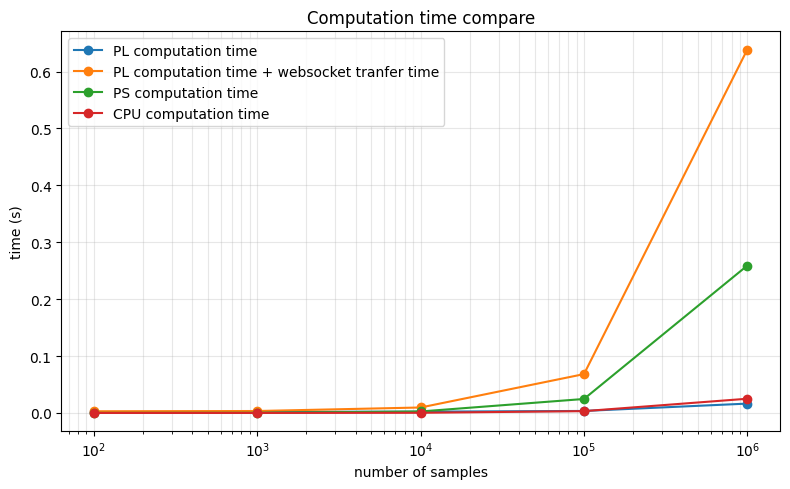

In [3]:
# Jupyter 單格版：只量三維 norm 計算時間，並畫圖（可選擇存檔）
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
import csv
import time

# 參數區（自己改）
sample_sizes = [100,1000,10000,100000,1000000]
LOW, HIGH = -128, 128
REPEAT = 5            # 每個樣本數重複量測次數，取平均
SEED = 12345          # 基礎亂數種子（會加上重複次數索引）
LOGX = True          # True 就用對數 X 軸
DO_SAVE = True       # True 就存 PNG 與 CSV
PNG_PATH = "norm_time.png"
CSV_PATH = "norm_time.csv"
PL_list = [0.0016970910000054574,
 0.0019166859999131703,
 0.0022577599998840014,
 0.0035303460000250197,
 0.016458752999915303]
PS_list = [0.0001589139998941391,
 0.0003887010001562885,
 0.0026233570001750195,
 0.024562847000015608,
 0.2590209940002751]

# 可選：避免中文標籤亂碼（若系統沒有對應字型就改用英文標籤）
import matplotlib

def time_norm_once(n_samples: int, low: int, high: int, seed: int | None = None):
    rng = np.random.default_rng(seed)
    input_array = rng.integers(low, high, size=n_samples*4+12, dtype=np.int16).astype(np.uint16)
    groups = input_array.reshape(-1, 4).astype(np.int64)
    packed_u64 = (groups[:, 3] << 48) | (groups[:, 2] << 32) | (groups[:, 1] << 16) | groups[:, 0]
    a = input_array[12:].reshape(-1, 4).astype(np.int16)
    b = input_array[:12].reshape(3, 4).astype(np.int16).T

    t0 = time.perf_counter()
    PS = a @ b
    PS_result = np.linalg.norm(PS.reshape(-1, 3), axis=1)
    t1 = time.perf_counter()
    PL_result = cli.run(packed_u64)
    t2 = time.perf_counter()
    return t1 - t0, t2 - t1

# 量測
n_list, t1_list, t2_list = [], [], []
for idx, n in enumerate(sample_sizes):
    acc1 = 0.0
    acc2 = 0.0
    for r in range(REPEAT):
        t1, t2 = time_norm_once(n, LOW, HIGH, seed=SEED + r)
        acc1 += t1
        acc2 += t2
    n_list.append(n)
    t1_list.append(acc1 / REPEAT)
    t2_list.append(acc2 / REPEAT)

# 可選：存檔
if DO_SAVE:
    plt.figure(figsize=(8, 5))
    plt.plot(n_list, PL_list, marker="o", linestyle="-", label="PL computation time")
    plt.plot(n_list, t2_list, marker="o", linestyle="-", label="PL computation time + websocket tranfer time")
    plt.plot(n_list, PS_list, marker="o", linestyle="-", label="PS computation time")
    plt.plot(n_list, t1_list, marker="o", linestyle="-", label="CPU computation time")
    if LOGX:
        plt.xscale("log")
    plt.xlabel("number of samples")
    plt.ylabel("time (s)")
    plt.title("Computation time compare")
    plt.grid(True, which="both", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(PNG_PATH, dpi=150)
    with open(CSV_PATH, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["n_samples", "PL_time_s", "PL_time_s + websocket tranfer time", "PS_time_s", "CPU_time_s"])
        for n, pl, t2, ps, t1 in zip(n_list, PL_list, t2_list, PS_list, t1_list):
            writer.writerow([n, f"{pl:.9f}", f"{t2:.9f}", f"{ps:.9f}", f"{t1:.9f}"])
    print(f"已存圖檔: {PNG_PATH}")
    print(f"已存 CSV: {CSV_PATH}")

In [6]:
t1_list[4]/PL_list[4]

1.518715300351951

In [61]:
sample_sizes = [20, 40, 60, 80, 100]
REPEAT = 3
n_list, t_list = [], []
for idx, n in enumerate(sample_sizes):
    acc = 0.0
    for r in range(REPEAT):
        t1 = time.perf_counter()
        geo_data.grid.regular_grid.resolution = np.array([n, n, n])
        gp.compute_model(geo_data)
        t2 = time.perf_counter()    
        acc += (t2 - t1)
    n_list.append(n)
    t_list.append(acc / REPEAT)

Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
Chunking done: 7 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 7 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 7 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 17 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 17 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 17 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 33 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 33 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 33 chunks


已存圖檔: norm_time.png
已存 CSV: norm_time.csv


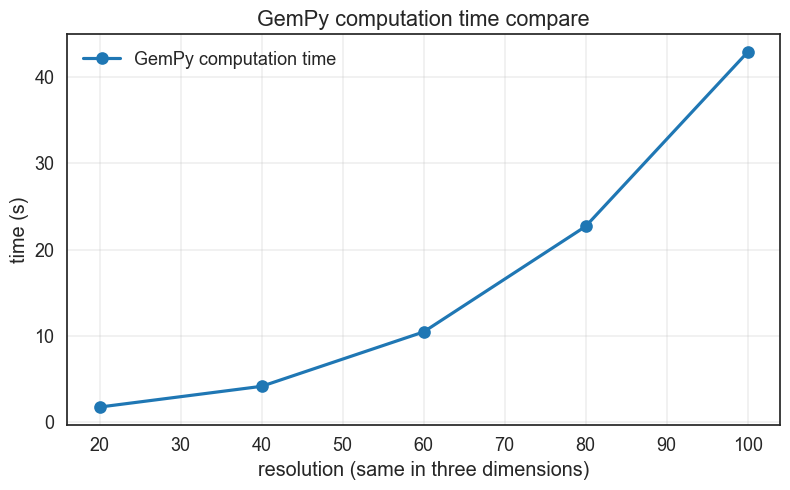

In [63]:
LOGX = False
if DO_SAVE:
    plt.figure(figsize=(8, 5))
    plt.plot(n_list, t_list, marker="o", linestyle="-", label="GemPy computation time")
    if LOGX:
        plt.xscale("log")
    plt.xlabel("resolution (same in three dimensions)")
    plt.ylabel("time (s)")
    plt.title("GemPy computation time compare")
    plt.grid(True, which="both", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(PNG_PATH, dpi=150)
    with open(CSV_PATH, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["n_samples", "GemPy compute time"])
        for n, t1 in zip(n_list, t_list):
            writer.writerow([n, f"{t1:.9f}"])
    print(f"已存圖檔: {PNG_PATH}")
    print(f"已存 CSV: {CSV_PATH}")

In [105]:
ran = 1000
res = 20
xx = np.arange(ran / res / 2, ran, ran / res)
yy = np.arange(ran / res / 2, ran, ran / res)
zz = np.arange(ran / res / 2, ran, ran / res)
x_real = (xx - X0) / SCALE
y_real = (yy - Y0) / SCALE
z_real = (zz - Z0) / SCALE
s = round((1 / SCALE) * 65536)
x = round((-X0/SCALE) * 65536)
y = round((-Y0/SCALE) * 65536)
z = round((-Z0/SCALE) * 65536)
S = np.eye(3,dtype=np.uint16) * s
T = np.array([[x], [y], [z]])
SRT = np.hstack([S, T])
SRT = SRT.ravel()
vector = interleave_with_one(xx, yy, zz)
input_array = np.concatenate((SRT, vector))
groups = input_array.reshape(-1, 4).astype(np.int64)
packed_u64 = (groups[:, 3] << 48) | (groups[:, 2] << 32) | (groups[:, 1] << 16) | groups[:, 0]
cli = PYNQClient("192.168.3.1")
cli.connect()
PL_result = cli.run(packed_u64)
PL_result = split_int64_to_int16_view(PL_result)[:, :3].reshape(-1, 3)
xx = (PL_result/65536)[:,0]
yy = (PL_result/65536)[:,1]
zz = (PL_result/65536)[:,2]
#sum(PL_result-PS_result)
print(f"x rmse: {np.sqrt(np.mean((xx - x_real) ** 2))}")
print(f"y rmse: {np.sqrt(np.mean((yy - y_real) ** 2))}")
print(f"z rmse: {np.sqrt(np.mean((zz - z_real) ** 2))}")

x rmse: 0.0003522765008732665
y rmse: 0.0003522765008732665
z rmse: 0.00034963609817068925


In [97]:
scalar_field_drift = np.empty((len(xx), len(yy), len(zz)))
t1 = time.perf_counter()
for ii,xxx in enumerate(xx):
    for j,yyy in enumerate(yy):
        for k,zzz in enumerate(zz):
            scalar_field_drift[ii, j, k] = interp_val_with_drift([xxx,yyy,zzz], w, i, o)
t2 = time.perf_counter()
print(t2 - t1)

1.0496159000322223


In [33]:
import time
def scalar_field_input(xa, i, o):
    return [K_ZGx(o[0] - xa),
            K_ZGx(o[1] - xa),
            K_ZGx(o[2] - xa),
            K_ZGy(o[0] - xa),
            K_ZGy(o[1] - xa),
            K_ZGy(o[2] - xa),
            K_ZGz(o[0] - xa),
            K_ZGz(o[1] - xa),
            K_ZGz(o[2] - xa),
            (K_Z(xa-i[0]) - K_Z(xa-i[1])),
            (K_Z(xa-i[0]) - K_Z(xa-i[2])),
            (K_Z(xa-i[3]) - K_Z(xa-i[4])),
            (K_Z(xa-i[3]) - K_Z(xa-i[5])),
            xa[0],
            xa[1],
            xa[2]]

ran = 1000
res = 20
xx = np.arange(ran / res / 2, ran, ran / res)
yy = np.arange(ran / res / 2, ran, ran / res)
zz = np.arange(ran / res / 2, ran, ran / res)
xx = (xx - X0) / SCALE
yy = (yy - Y0) / SCALE
zz = (zz - Z0) / SCALE
# [ii,j,k,:]存scalar_field_input的return（長度16）
scalar_field_list = np.empty((len(xx), len(yy), len(zz), 16))
t1 = time.perf_counter()
for ii, xxx in enumerate(xx):
    for j, yyy in enumerate(yy):
        for k, zzz in enumerate(zz):
            scalar_field_list[ii, j, k, :] = scalar_field_input([xxx, yyy, zzz], i, o)
t2 = time.perf_counter()
print(t2 - t1)

1.0659455999266356


In [34]:
scalar_field_drift = scalar_field_list @ w

In [42]:
scalar_field_drift.max()

np.float64(0.8233144831832546)

In [18]:
print(f'rmse: {np.sqrt(np.mean((test - scalar_field_drift)**2))}')

rmse: 1.4571934418564348e-06


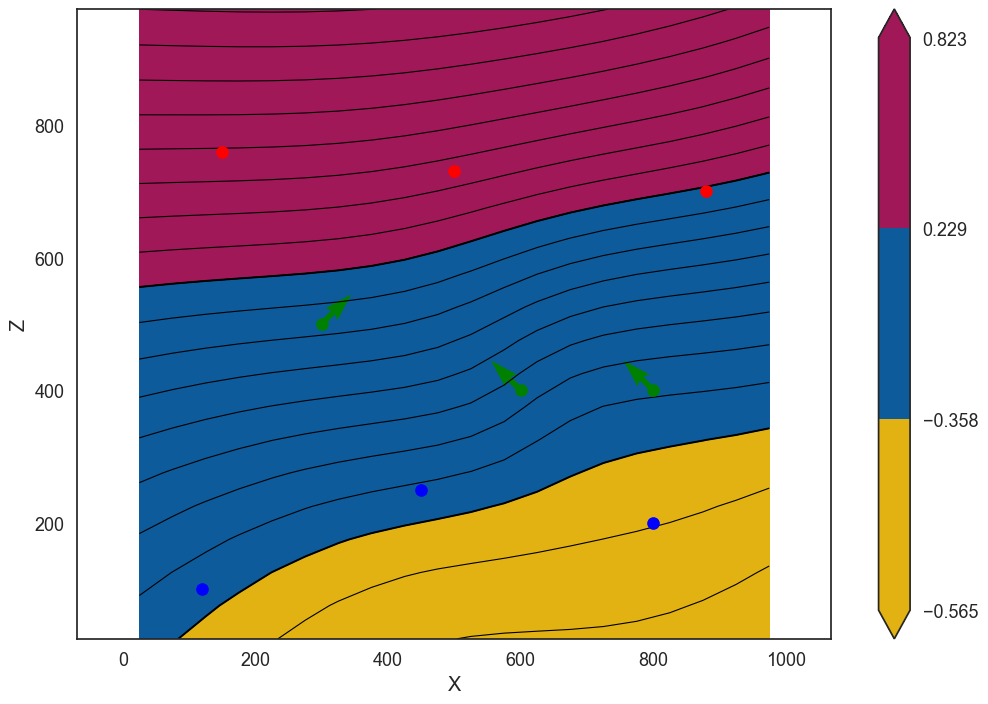

In [35]:
# 1) 取 x–z 平面：固定一個 y 索引（例如中間那層）
y_idx = 0   # 或自訂：y_idx = np.argmin(np.abs((Y0+SCALE*yy) - y0_target))

# 2) 1D 原座標軸（注意：只對座標反正規化）
x1 = X0 + SCALE * np.asarray(xx, float)     # 長度 nx
z1 = Z0 + SCALE * np.asarray(zz, float)     # 長度 nz

# 3) 取切片並轉置成 (nz, nx) 以配合 (y, x) 的順序
Sxz = np.asarray(scalar_field_drift[:, y_idx, :], float).T   # (nz, nx)

# 4) 層面值（通常是位勢，不縮放；除非你之前把場值也除過 1520）
l1 = float(interp_val_with_drift(i[0], w, i, o))
l2 = float(interp_val_with_drift(i[3], w, i, o))
l1, l2 = sorted([l1, l2])

# 5) 色階
lo, hi = float(np.nanmin(Sxz)), float(np.nanmax(Sxz))
eps = np.finfo(float).eps * max(1.0, abs(hi - lo))
bounds = [b for b in (l1, l2) if np.isfinite(b) and (lo < b < hi)]
levels_fill = np.unique(np.r_[lo - eps, bounds, hi + eps])   # 嚴格遞增
palette = ["#E2B213", "#0D5B9B", "#A01857"]
colors = palette[:max(1, len(levels_fill) - 1)]

# 6) 繪圖（用 1D 座標）
h = plt.contourf(x1, z1, Sxz, levels=levels_fill, colors=colors, extend='both')
plt.colorbar(h, extend='both')

# 等距等高線
if np.isfinite(l1) and np.isfinite(l2) and (l2 > l1):
    m_between = 8
    d = (l2 - l1) / max(1, m_between)
    kmin = int(np.floor((lo - l1) / d))
    kmax = int(np.ceil( (hi - l1) / d))
    levels_lines = l1 + d * np.arange(kmin, kmax + 1)
else:
    levels_lines = np.linspace(lo, hi, 20)
levels_lines = levels_lines[(levels_lines > lo - eps) & (levels_lines < hi + eps)]
for b in (l1, l2):
    if lo < b < hi:
        levels_lines = np.unique(np.r_[levels_lines, b])

plt.contour(x1, z1, Sxz, levels=levels_lines, colors='k', linewidths=0.8, linestyles='solid')
plt.contour(x1, z1, Sxz, levels=[b for b in (l1, l2) if lo < b < hi],
            colors='k', linewidths=1.4, linestyles='solid')

# 7) 投影資料點與向量到 x–z（座標反正規化，向量乘回 SCALE）
ix = X0 + SCALE * i[:, 0]; iy = Y0 + SCALE * i[:, 1]; iz = Z0 + SCALE * i[:, 2]
ox = X0 + SCALE * o[:, 0]; oy = Y0 + SCALE * o[:, 1]; oz = Z0 + SCALE * o[:, 2]
plt.plot(ix[0], iz[0], 'bo'); plt.plot(ix[1], iz[1], 'bo'); plt.plot(ix[2], iz[2], 'bo')
plt.plot(ix[3], iz[3], 'ro'); plt.plot(ix[4], iz[4], 'ro'); plt.plot(ix[5], iz[5], 'ro')
plt.plot(ox[0], oz[0], 'go'); plt.plot(ox[1], oz[1], 'go'); plt.plot(ox[2], oz[2], 'go')

plt.quiver(ox[0], oz[0], SCALE*gx0, SCALE*gz0, color='g')
plt.quiver(ox[1], oz[1], SCALE*gx1, SCALE*gz1, color='g')
plt.quiver(ox[2], oz[2], SCALE*gx2, SCALE*gz2, color='g')

plt.xlabel("X")
plt.ylabel("Z")
plt.axis('equal'); plt.tight_layout(); plt.show()


In [36]:
labels = np.where(scalar_field_drift<=l1, 3, np.where(scalar_field_drift<=l2, 2, 1))


In [37]:
idx = np.flatnonzero(labels.ravel() - geo_data.solutions.raw_arrays.lith_block)
print(f'number of errors: {idx.size}\nfall at point: {idx}')
if idx.size == 0:
    print('all pass')


number of errors: 0
fall at point: []
all pass


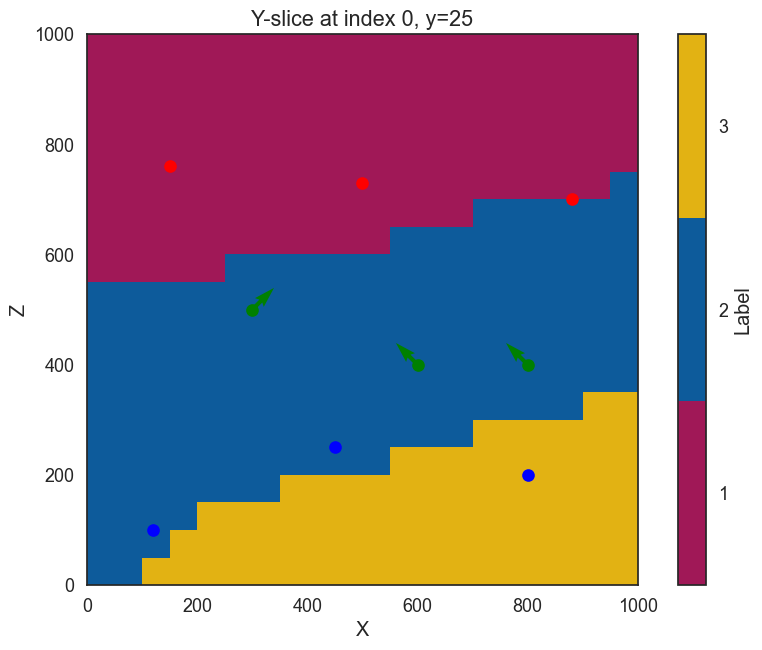

In [119]:
# 在前一版基礎上，加入 colors = ["#E2B213", "#0D5B9B", "#A01857"]
# 以離散 colormap 嚴格對應標籤：1→colors[0], 2→colors[1], 3→colors[2]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

def render_y_slice(labels, x_range, y_range, z_range, nx, ny, nz, y_sel=None, y_index=None, colors=None, show=True):
    """
    labels: 3D 陣列，shape=(Nz,Ny,Nx)，值為 {1,2,3}
    colors: 3 色 hex 或 RGB，可選，預設 ["#E2B213","#0D5B9B","#A01857"]
            對應 1→colors[0], 2→colors[1], 3→colors[2]
    其餘參數同前
    """
    labels = np.asarray(labels)
    if labels.shape != (nz, ny, nx):
        raise ValueError(f"labels.shape 應為 (Nz, Ny, Nx)=({nz},{ny},{nx})，但實際為 {labels.shape}")
    
    if colors is None:
        colors = ["#E2B213", "#0D5B9B", "#A01857"]
    if len(colors) != 3:
        raise ValueError("colors 必須包含 3 個顏色。")
    
    x0, x1 = x_range
    y0, y1 = y_range
    z0, z1 = z_range

    dx = (x1 - x0) / nx
    dy = (y1 - y0) / ny
    dz = (z1 - z0) / nz

    x_centers = x0 + (np.arange(nx) + 0.5) * dx
    y_centers = y0 + (np.arange(ny) + 0.5) * dy
    z_centers = z0 + (np.arange(nz) + 0.5) * dz

    if y_sel is not None:
        y_index = int(np.argmin(np.abs(y_centers - y_sel)))
    elif y_index is None:
        y_index = ny // 2
    if not (0 <= y_index < ny):
        raise ValueError(f"y_index 超出範圍：0..{ny-1}, 得到 {y_index}")
    
    # 垂直於 y 的切片：取得 (z,x) 平面
    slice2d = labels[:, y_index, :]  # (Nz, Nx)

    # 建立離散 colormap 與對應的 BoundaryNorm，讓 1/2/3 精準落到三種顏色
    cmap = ListedColormap(colors)
    norm = BoundaryNorm([0.5, 1.5, 2.5, 3.5], cmap.N)
    
    if show:
        plt.figure()
        im = plt.imshow(
            slice2d,
            origin="lower",
            extent=[x0, x1, z0, z1],
            cmap=cmap,
            norm=norm,
            interpolation="nearest"
        )
        cbar = plt.colorbar(im)
        cbar.set_ticks([1, 2, 3])
        cbar.set_label("Label")
        plt.plot(ix[0], iz[0], 'bo'); plt.plot(ix[1], iz[1], 'bo'); plt.plot(ix[2], iz[2], 'bo')
        plt.plot(ix[3], iz[3], 'ro'); plt.plot(ix[4], iz[4], 'ro'); plt.plot(ix[5], iz[5], 'ro')
        plt.plot(ox[0], oz[0], 'go'); plt.plot(ox[1], oz[1], 'go'); plt.plot(ox[2], oz[2], 'go')

        plt.quiver(ox[0], oz[0], SCALE*gx0, SCALE*gz0, color='g')
        plt.quiver(ox[1], oz[1], SCALE*gx1, SCALE*gz1, color='g')
        plt.quiver(ox[2], oz[2], SCALE*gx2, SCALE*gz2, color='g')
        plt.xlabel("X")
        plt.ylabel("Z")
        plt.title(f"Y-slice at index {y_index}, y={y_centers[y_index]:.4g}")
        plt.show()
    
    return slice2d, (x_centers, y_centers, z_centers), y_index

# ---- Demo：建立一個簡單的標籤體，隨機 1/2/3（您可換成自己的 labels）----
nx, ny, nz = 20, 20, 20

# 定義渲染範圍（以實際單位或任意座標系）
x_range = (0, 1000)
y_range = (0, 1000)
z_range = (0, 1000)

# 以 y 的座標值取切片（例如 y=0.75）
_, _, fig_slice  = render_y_slice(labels.T, x_range, y_range, z_range, nx, ny, nz, y_sel=0, colors=[ "#A01857", "#0D5B9B", "#E2B213"],show=True)


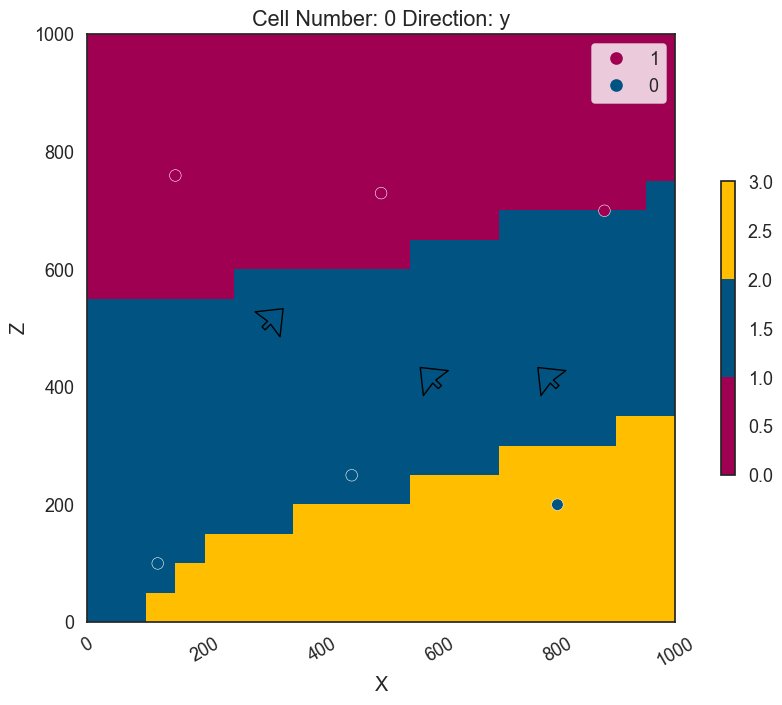

In [120]:
plot = gpv.plot_2d(geo_data, show_lith=True, show_boundaries=False, direction= 'y', cell_number=0).fig

In [86]:
import pyvista as pv
# --- 判斷是否在 notebook，選用合適的互動後端 ---
def _in_notebook():
    try:
        from IPython import get_ipython
        return get_ipython() is not None and "ipykernel" in sys.modules
    except Exception:
        return False

IN_NOTEBOOK = _in_notebook()
if IN_NOTEBOOK:
    try:
        pv.set_jupyter_backend('pythreejs')  # 互動 3D 後端
    except Exception:
        pv.set_jupyter_backend('client')     # 備援

# ====== 你的資料 ======
# xx, yy, zz 為「正規化後」1D 座標；Z3 為 3D 標量場 (nx, ny, nz)
Z3 = np.asarray(labels, float)
l1, l2 = 2, 1

# ── (可選) 只有當你曾經把「標量場的值本身」也除以 1520 時，才要放大回來 ──
# Z3 = SCALE * Z3
# l1, l2 = SCALE * l1, SCALE * l2

# ====== 反正規化座標軸 ======
xx_o = X0 + SCALE * np.asarray(xx, float)
yy_o = Y0 + SCALE * np.asarray(yy, float)
zz_o = Z0 + SCALE * np.asarray(zz, float)

# ====== PyVista 影像網格（UniformGrid）======
nx, ny, nz = Z3.shape
dx = float(xx_o[1] - xx_o[0]) if len(xx_o) > 1 else 1.0
dy = float(yy_o[1] - yy_o[0]) if len(yy_o) > 1 else 1.0
dz = float(zz_o[1] - zz_o[0]) if len(zz_o) > 1 else 1.0

grid = pv.ImageData()
grid.dimensions = (nx, ny, nz)  # 點數；要與 Z3.shape 對上
grid.spacing    = (dx, dy, dz)
grid.origin     = (float(xx_o.min()), float(yy_o.min()), float(zz_o.min()))
grid['s']       = Z3.ravel(order='F')  # 以點為標量（Fortran 展平，對應 nx-ny-nz 順序）

# ====== 三色體渲染（<l1 黃、l1~l2 藍、≥l2 紅）======
#lo, hi = float(np.nanmin(Z3)), float(np.nanmax(Z3))
lo, hi = 0, 3
eps = 1e-12

L = np.array([1,2,3])
grid['level'] = np.digitize(grid['s'], (L[1:]+L[:-1])/2) + 1  # 1/2/3 分類
high = grid.extract_points(grid['level']==1, adjacent_cells=True)
mid  = grid.extract_points(grid['level']==2, adjacent_cells=True)
low  = grid.extract_points(grid['level']==3, adjacent_cells=True)


p = pv.Plotter(notebook=IN_NOTEBOOK)

def add_if_not_empty(mesh, **kwargs):
    if hasattr(mesh, "n_cells") and mesh.n_cells > 0:
        p.add_mesh(mesh, **kwargs)

add_if_not_empty(low,  color="#E2B213", opacity=0.25, show_edges=False)  # 黃
add_if_not_empty(mid,  color="#0D5B9B", opacity=0.25, show_edges=False)  # 藍
add_if_not_empty(high, color="#A01857", opacity=0.25, show_edges=False)  # 紅

# ====== 邊界等值面（l1 / l2）======
#iso_levels = [v for v in (l1, l2) if lo < v < hi]
#for val, color in zip(iso_levels, ["#0D5B9B", "#A01857"]):
#    surf = grid.contour(isosurfaces=[val], scalars='s')
#    if surf.n_cells > 0:
#        p.add_mesh(surf, color=color, opacity=0.6, show_edges=True)

# ====== 外觀與互動 ======
p.add_axes(); p.show_grid()
p.camera_position = 'iso'
p.enable_anti_aliasing()
p.show()


Widget(value='<iframe src="http://localhost:9809/index.html?ui=P_0x2abea94c550_0&reconnect=auto" class="pyvist…

In [87]:
gpv.plot_3d(geo_data, show_surfaces=False, image=False, show_data=False)

In [88]:
geo_data.solutions.raw_arrays.lith_block = labels.ravel()
gpv.plot_3d(geo_data, show_surfaces=False, image=False, show_data=False)

In [121]:
gempy_matrix = geo_data.solutions.debug_input_data['A_matrix']
rmse = np.sqrt(np.mean((gempy_matrix - krig_full)**2))
print(f'rmse: {np.sqrt(np.mean((gempy_matrix - krig_full)**2))}')
print(f'max abs error: {np.max(abs(krig_full - gempy_matrix))}')


rmse: 2.398331794699288e-09
max abs error: 1.0169280528771196e-08


In [90]:
pd.DataFrame(krig_full - gempy_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000e+00,3.317567e-09,9.443291e-10,0.000000e+00,1.885375e-09,3.367955e-09,0.000000e+00,2.356718e-10,1.122651e-09,-4.489006e-09,-2.897657e-09,-4.330051e-09,-4.909397e-09,0.000000e+00,0.000000e+00,0.000000e+00
1,3.317567e-09,0.000000e+00,6.151961e-09,1.885375e-09,0.000000e+00,-2.938252e-09,2.356718e-10,0.000000e+00,0.000000e+00,-5.549083e-09,2.572014e-10,-6.127387e-09,-2.222450e-09,0.000000e+00,0.000000e+00,0.000000e+00
2,9.443291e-10,6.151961e-09,0.000000e+00,3.367955e-09,-2.938252e-09,0.000000e+00,1.122651e-09,0.000000e+00,0.000000e+00,-4.136155e-09,-6.237144e-10,-4.810055e-09,-9.237429e-10,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000e+00,1.885375e-09,3.367955e-09,0.000000e+00,-1.003082e-09,4.536812e-09,0.000000e+00,-6.284586e-10,-6.735910e-10,1.061311e-09,2.161435e-09,-6.672884e-10,-2.166150e-09,0.000000e+00,0.000000e+00,0.000000e+00
4,1.885375e-09,0.000000e+00,-2.938252e-09,-1.003082e-09,0.000000e+00,-1.837108e-11,-6.284586e-10,0.000000e+00,0.000000e+00,2.189591e-10,-1.804654e-10,1.434882e-09,-1.175229e-09,0.000000e+00,0.000000e+00,0.000000e+00
5,3.367955e-09,-2.938252e-09,0.000000e+00,4.536812e-09,-1.837108e-11,0.000000e+00,-6.735910e-10,0.000000e+00,0.000000e+00,4.899015e-09,3.819631e-09,3.626717e-09,-2.293193e-09,0.000000e+00,0.000000e+00,0.000000e+00
6,0.000000e+00,2.356718e-10,1.122651e-09,0.000000e+00,-6.284586e-10,-6.735910e-10,0.000000e+00,3.946031e-09,6.333057e-09,-2.588692e-09,-2.449051e-09,1.977789e-09,-8.301115e-10,0.000000e+00,0.000000e+00,0.000000e+00
7,2.356718e-10,0.000000e+00,0.000000e+00,-6.284586e-10,0.000000e+00,0.000000e+00,3.946031e-09,0.000000e+00,7.327259e-09,1.383272e-09,1.218542e-09,-1.326754e-09,3.363410e-10,0.000000e+00,0.000000e+00,0.000000e+00
8,1.122651e-09,0.000000e+00,0.000000e+00,-6.735910e-10,0.000000e+00,0.000000e+00,6.333057e-09,7.327259e-09,0.000000e+00,1.035733e-09,-3.194431e-10,-8.447865e-10,-1.165650e-09,0.000000e+00,0.000000e+00,0.000000e+00
9,-4.489006e-09,-5.549083e-09,-4.136155e-09,1.061311e-09,2.189591e-10,4.899015e-09,-2.588692e-09,1.383272e-09,1.035733e-09,1.003237e-08,6.281564e-09,4.390113e-09,9.818768e-10,0.000000e+00,0.000000e+00,0.000000e+00
